In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier


In [2]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

In [3]:
inner_cv = StratifiedKFold(n_splits = 3, shuffle=True,random_state=42)
outer_cv = StratifiedKFold(n_splits = 10, shuffle=True,random_state=42)

Make Grid Search for Random Forest models.

In [4]:
hyperparams_RF = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5, 10, 20],
    'n_estimators' : [20,50,100]
}

grid_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=hyperparams_RF,
    scoring='roc_auc',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_RF = cross_validate(grid_RF, X=X, y=y, cv=outer_cv, scoring=["roc_auc", "accuracy"], return_train_score=True)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 

In [5]:
df = pd.DataFrame(scores_RF)

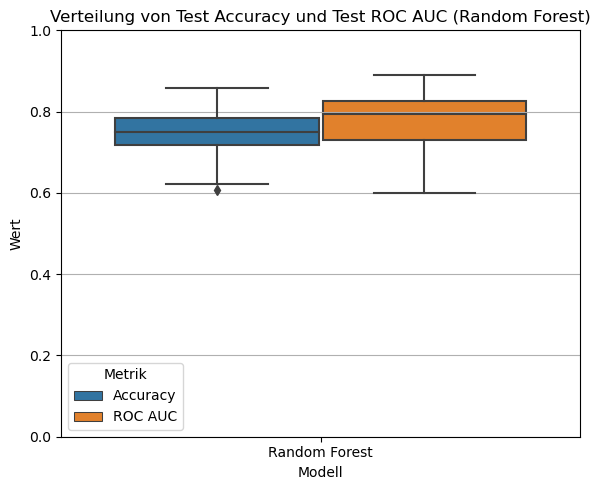

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Beispiel: DataFrame df aus cross_validate
# df = pd.DataFrame(scores_RF)

# Daten für Boxplot vorbereiten
plot_data = pd.DataFrame({
    'Metrik': ['Accuracy'] * len(df) + ['ROC AUC'] * len(df),
    'Wert': list(df['test_accuracy']) + list(df['test_roc_auc']),
    'Modell': ['Random Forest'] * (2 * len(df))  # Dummy-Spalte für konsistente X-Achse
})

# Plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=plot_data, x='Modell', y='Wert', hue='Metrik')

plt.title('Verteilung von Test Accuracy und Test ROC AUC (Random Forest)')
plt.ylim(0.0, 1.0)
plt.grid(axis='y')
plt.legend(title='Metrik', loc='lower left')
plt.tight_layout()
plt.show()


In [7]:
model_evaluation = pd.DataFrame({"Fold": range(1, 11)})
model_evaluation['Modell'] = ['Random Forest'] * 10
model_evaluation['ROC_AUC'] = df['test_roc_auc']
model_evaluation['Accuracy'] = df['test_accuracy']
model_evaluation

,Fold,Modell,ROC_AUC,Accuracy
0,1,Random Forest,0.872222,0.827586
1,2,Random Forest,0.800000,0.793103
2,3,Random Forest,0.833333,0.758621
3,4,Random Forest,0.677778,0.620690
4,5,Random Forest,0.794444,0.724138
5,6,Random Forest,0.888889,0.750000
6,7,Random Forest,0.795322,0.857143
7,8,Random Forest,0.599415,0.607143
8,9,Random Forest,0.750000,0.750000
9,10,Random Forest,0.725000,0.714286


In [8]:
model_evaluation.to_pickle('model_evaluation/Random_Forest.pkl')